# Machine Translation

* Neural Machine Translation (NMT) model to translate human-readable dates ("25th of June, 2009") into machine-readable dates ("2009-06-25")
* Using an attention model, one of the most sophisticated sequence-to-sequence models
* While the model can be used to translate from one language to another - due to lack of compute resources and training data, we use a simpler example

## Attention Model

The attention mechanism tells a Neural Machine Translation model where it should pay attention to at any step. Below diagrams show how the model works. 
* The diagram on the left shows the attention model. 
* The diagram on the right shows what one "attention" step does to calculate the attention variables $\alpha^{\langle t, t' \rangle}$.
* Attention variables $\alpha^{\langle t, t' \rangle}$ are used to compute the context variable $context^{\langle t \rangle}$ for each o/p timestep ($t=1, \ldots, T_y$). 

<table>
<td><img src="images/attn_model.png" style="width:500;height:400px;"> <br></td> 
<td><img src="images/attn_mechanism.png" style="width:500;height:400px;"> <br></td> 
</table>
<caption><center>Neural machine translation with attention</center></caption>

### Pre-attention and Post-attention LSTMs on both sides of the attention mechanism
- There are two separate LSTMs in this model (see diagram on the left): pre-attention and post-attention LSTMs.
  - **Pre-attention Bi-LSTM** comes *before* the attention mechanism and goes through $T_x$ time steps
  - **Post-attention LSTM** comes *after* the attention mechanism and goes through $T_y$ time steps. 
    - Post-attention LSTM passes the hidden state $s^{\langle t \rangle}$ and cell state $c^{\langle t \rangle}$ from one time step to the next.
    - Unlike text generation examples, the post-attention LSTM at time $t$ does not take $y^{\langle t-1 \rangle}$ as input.
    - Post-attention LSTM at time 't' only takes the hidden state $s^{\langle t\rangle}$ and cell state $c^{\langle t\rangle}$ as input. 
    - We have designed the model this way because unlike language generation (where adjacent characters are highly correlated) there isn't as strong a dependency between the previous character and the next character in a YYYY-MM-DD date.
    
### Computing "Energies" $e^{\langle t, t' \rangle}$ as a function of $s^{\langle t-1 \rangle}$ and $a^{\langle t' \rangle}$
- Note that the diagram doesn't explicitly show variable $e^{\langle t, t' \rangle}$, but $e^{\langle t, t' \rangle}$ **is above the Dense layer and below the Softmax layer**
- $s^{\langle t-1 \rangle}$ is the hidden state of the post-attention LSTM
- $a^{\langle t' \rangle}$ is the hidden state of the pre-attention LSTM.
- $s^{\langle t-1 \rangle}$ and $a^{\langle t \rangle}$ are fed into a simple neural network, which learns the function to output $e^{\langle t, t' \rangle}$.
- $e^{\langle t, t' \rangle}$ is then used when computing the attention $\alpha^{\langle t, t' \rangle}$ that $y^{\langle t \rangle}$ should pay to $a^{\langle t' \rangle}$.

In [1]:
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Model
import tensorflow.keras.backend as K
import tensorflow as tf

import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

from faker import Faker
from tqdm import tqdm    # prints a dynamically updating progressbar
from babel.dates import format_date

## Creating Dataset

In [2]:
# Creates dates in proper and improper formats

FORMATS = ['short','medium','long','full','full','full','full','full','full','full','full',
           'full','full','d MMM YYY','d MMMM YYY','dd MMM YYY','d MMM, YYY','d MMMM, YYY',
           'dd, MMM YYY','d MM YY','d MMMM YYY','MMMM d YYY','MMMM d, YYY','dd.MM.YY']

fake = Faker()

def load_date():
    dt = fake.date_object()
    human_readable = format_date(dt, format=random.choice(FORMATS),locale='en_US')
    human_readable = human_readable.lower().replace(',','')
    machine_readable = dt.isoformat()
        
    return human_readable, machine_readable, dt

In [3]:
def load_dataset(m):
    """Loads a dataset with m examples and vocabularies"""    
    human_vocab = set()
    machine_vocab = set()
    dataset = []

    for i in tqdm(range(m)):
        h, m, _ = load_date()
        dataset.append((h, m))
        human_vocab.update(tuple(h))
        machine_vocab.update(tuple(m))
    
    human = dict(zip(sorted(human_vocab) + ['<unk>', '<pad>'],
                     list(range(len(human_vocab) + 2))))
    inv_machine = dict(enumerate(sorted(machine_vocab)))
    machine = {v:k for k,v in inv_machine.items()}
 
    return dataset, human, machine, inv_machine

In [4]:
# human_vocab: dictionary mapping characters used in human readable dates to an integer index.
# machine_vocab: dictionary mapping characters used in machine readable dates to an integer index

m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 18673.96it/s]


In [5]:
dataset[:10]

[('24 nov 1984', '1984-11-24'),
 ('27 jul 1993', '1993-07-27'),
 ('tuesday july 11 1972', '1972-07-11'),
 ('november 21 1997', '1997-11-21'),
 ('may 29 2014', '2014-05-29'),
 ('17 may 1982', '1982-05-17'),
 ('19 mar 2002', '2002-03-19'),
 ('wednesday march 10 1982', '1982-03-10'),
 ('friday january 13 2017', '2017-01-13'),
 ('tuesday august 7 2007', '2007-08-07')]

In [6]:
# human_vocab #, machine_vocab, inv_machine_vocab

In [7]:
max([len(i[0]) for i in dataset])

27

In [8]:
Tx = 30   # maximum length of the human readable date
Ty = 10   # "YYYY-MM-DD" is 10 characters long.


def string_to_int(string, maxLen, vocab):
    """ converts string to integers using vocab dictionary """
    string = string.lower().replace(',','')
    if len(string) > maxLen:
        string = string[:maxLen]
    else:
        string = list(string) + ['<pad>'] * (maxLen - len(string))
        
    return list(map(lambda x: vocab.get(x, '<unk>'), string))
    
def preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty):
    X, Y = zip(*dataset)
    
    X = np.array([string_to_int(i, Tx, human_vocab) for i in X])
    Y =          [string_to_int(t, Ty, machine_vocab) for t in Y]
    
    Xoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), X)))
    Yoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(machine_vocab)), Y)))

    return X, np.array(Y), Xoh, Yoh

X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)
print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: (10000, 30, 37)
Yoh.shape: (10000, 10, 11)


In [9]:
index = 0
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing:", X[index])
print("Target after preprocessing:", Y[index])
print()
print("Source after preprocessing (one-hot):", Xoh[index])
print("Target after preprocessing (one-hot):", Yoh[index])

Source date: 24 nov 1984
Target date: 1984-11-24

Source after preprocessing: [ 5  7  0 25 26 32  0  4 12 11  7 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36]
Target after preprocessing: [ 2 10  9  5  0  2  2  0  3  5]

Source after preprocessing (one-hot): [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Target after preprocessing (one-hot): [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


---
## Helper Function for Attention Model

#### `one_step_attention`
* The inputs to the one_step_attention at time step $t$ are:
    - $[a^{<1>},a^{<2>}, ..., a^{<T_x>}]$: all hidden states of the pre-attention Bi-LSTM.
    - $s^{<t-1>}$: the previous hidden state of the post-attention LSTM 
* one_step_attention computes:
    - $[\alpha^{<t,1>},\alpha^{<t,2>}, ..., \alpha^{<t,T_x>}]$: the attention weights
    - $context^{ \langle t \rangle }$: the context vector:
    
$$context^{<t>} = \sum_{t' = 1}^{T_x} \alpha^{<t,t'>}a^{<t'>}$$ 


* The function `model()` will call the layers in `one_step_attention()` $T_y$ times using a for-loop.
* It is important that **all $T_y$ copies have the same weights. It should not reinitialize the weights every time.**
* To implement layers with shareable weights in Keras:
    1. Define the layer objects in a variable scope that is outside of function.E.g. defining the objects as global variables would work.
    2. Call these objects when propagating the input.

References:
* [RepeatVector()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RepeatVector) : var_repeated = repeat_layer(var1)
* [Concatenate()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate) : concatenated_vars = concatenate_layer([var1,var2,var3])
* [Dense()](https://keras.io/layers/core/#dense) : var_out = dense_layer(var_in)
* [Activation()](https://keras.io/layers/core/#activation): activation = activation_layer(var_in)
* [Dot()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dot) : dot_product = dot_layer([var1,var2])

In [10]:
def softmax(x, axis=1):
    """Softmax activation function.
    # Arguments: x (tensor), axis (axis along which the softmax normalization is applied)
    # Raises: ValueError: In case `dim(x) == 1`.
    """
    ndim = K.ndim(x)
    if ndim == 2:
        return K.softmax(x)
    elif ndim > 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D')

In [11]:
# Defined shared layers as global variables
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights')
dotor = Dot(axes = 1)

In [12]:
def one_step_attention(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.
    
    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    Returns:
    context -- context vector, input of the next (post-attention) LSTM cell
    """
    
    s_prev = repeator(s_prev)           # repeat s_prev to become (m, Tx, n_s) so it can concatenate with all hidden states "a"
    concat = concatenator([a, s_prev])  # concatenate
    e = densor1(concat)                 # each 't' is propagated through a Dense(10) layer to get (m, Tx, 10) [self note]
    energies = densor2(e)               # (m, Tx, 1) [self note]
    alphas = activator(energies)        # (m, Tx, 1)
    context = dotor([alphas, a])        # (m, 1, 2*n_a)
    
#     print(s_prev.shape)
#     print(concat.shape)
#     print(e.shape)
#     print(energies.shape)
#     print(alphas.shape)
#     print(context.shape)
    return context

#### `modelf()`

* `modelf` first runs the input through a Bi-LSTM to get $[a^{<1>},a^{<2>}, ..., a^{<T_x>}]$. 
* Then, `modelf` calls `one_step_attention()` $T_y$ times using a `for` loop.  At each iteration of this loop:
    - It gives the computed context vector $context^{<t>}$ to the post-attention LSTM.
    - It runs the output of the post-attention LSTM through a dense layer with softmax activation.
    - The softmax generates a prediction $\hat{y}^{<t>}$.
    
Again, we have defined global layers that will share weights to be used in `modelf()`.

In [13]:
n_a = 32   # number of units for the pre-attention, bi-directional LSTM's hidden state 'a'
n_s = 64   # number of units for the post-attention LSTM's hidden state "s"

# Post attention LSTM cell
post_activation_LSTM_cell = LSTM(n_s, return_state = True)
output_layer = Dense(len(machine_vocab), activation=softmax)

In [14]:
def modelf(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    human_vocab_size -- size of the python dictionary "human_vocab"
    machine_vocab_size -- size of the python dictionary "machine_vocab"

    Returns:
    model -- Keras model instance
    """
    
    # Define the inputs of your model with a shape (Tx,)
    # Define s0 (initial hidden state) and c0 (initial cell state)
    # for the decoder LSTM with shape (n_s,)
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = []
    
    # Define your pre-attention Bi-LSTM
    a = Bidirectional(LSTM(n_a, return_sequences=True))(X)
    
    # Iterate for Ty steps
    for t in range(Ty):
    
        # Perform one step of the attention mechanism to get the context vector at t
        context = one_step_attention(a, s)
        
        # Post-attention LSTM cell to "context" vector. (initial_state = [hidden state, cell state])
        s, _, c = post_activation_LSTM_cell(context, initial_state=[s, c])
        
        # Dense layer to the hidden state output of the post-attention LSTM
        out = output_layer(s)
        
        # Gather outputs
        outputs.append(out)
    
    # Create model instance
    model = Model(inputs = [X, s0, c0], outputs = outputs)
    
    return model

In [16]:
model = modelf(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))

In [17]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 30, 37)]     0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 [(None, 64)]         0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 64)       17920       input_2[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 30, 64)       0           s0[0][0]                         
                                                                 lstm[10][0]           

In [19]:
model.compile(loss = 'categorical_crossentropy', 
              optimizer = Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999, decay=0.01),
              metrics = ['accuracy'])

In [20]:
model.load_weights('pretrainedmodel/attention_model_dates/model.h5')

In [21]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
s00 = np.zeros((1, n_s))
c00 = np.zeros((1, n_s))
for example in EXAMPLES:
    source = string_to_int(example, Tx, human_vocab)
    #print(source)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source))).swapaxes(0,1)
    source = np.swapaxes(source, 0, 1)
    source = np.expand_dims(source, axis=0)
    prediction = model.predict([source, s00, c00])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    print("source:", example)
    print("output:", ''.join(output),"\n")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
source: 3 May 1979
output: 1979-05-33 

source: 5 April 09
output: 2009-04-05 

source: 21th of August 2016
output: 2016-08-20 

source: Tue 10 Jul 2007
output: 2007-07-10 

source: Saturday May 9 2018
output: 2018-05-09 

source: March 3 2001
output: 2001-03-03 

source: March 3rd 2001
output: 2001-03-03 

source: 1 March 2001
output: 2001-03-01 



In [24]:
def int_to_string(ints, inv_vocab):
    return [inv_vocab[i] for i in ints]

def plot_attention_map(modelx, input_vocabulary, inv_output_vocabulary, text, n_s = 128, num = 7):
    """
    Plot the attention map.
  
    """
    attention_map = np.zeros((10, 30))
    human_vocab_size = 37
    
    layer = modelx.get_layer('attention_weights')
    Ty, Tx = attention_map.shape
    
    # Well, this is cumbersome but this version of tensorflow-keras has a bug that affects the 
    # reuse of layers in a model with the functional API. 
    # So, I have to recreate the model based on the functional 
    # components and connect then one by one.
    # ideally it can be done simply like this:
    # layer = modelx.layers[num]
    # f = Model(modelx.inputs, [layer.get_output_at(t) for t in range(Ty)])
    #
    
    X = modelx.inputs[0] 
    s0 = modelx.inputs[1] 
    c0 = modelx.inputs[2] 
    s = s0
    c = s0
    
    a = modelx.layers[2](X)  
    outputs = []

    for t in range(Ty):
        s_prev = s
        s_prev = modelx.layers[3](s_prev)
        concat = modelx.layers[4]([a, s_prev]) 
        e = modelx.layers[5](concat) 
        energies = modelx.layers[6](e) 
        alphas = modelx.layers[7](energies) 
        context = modelx.layers[8]([alphas, a])
        s, _, c = modelx.layers[10](context, initial_state = [s, c]) 
        outputs.append(energies)

    f = Model(inputs=[X, s0, c0], outputs = outputs)
    
    s0 = np.zeros((1, n_s))
    c0 = np.zeros((1, n_s))
    encoded = np.array(string_to_int(text, Tx, input_vocabulary)).reshape((1, 30))
    encoded = np.array(list(map(lambda x: to_categorical(x, num_classes=len(input_vocabulary)), encoded)))

    r = f([encoded, s0, c0])
        
    for t in range(Ty):
        for t_prime in range(Tx):
            attention_map[t][t_prime] = r[t][0, t_prime]

    # Normalize attention map
    row_max = attention_map.max(axis=1)
    attention_map = attention_map / row_max[:, None]

    prediction = modelx.predict([encoded, s0, c0])
    
    predicted_text = []
    for i in range(len(prediction)):
        predicted_text.append(int(np.argmax(prediction[i], axis=1)))
        
    predicted_text = list(predicted_text)
    predicted_text = int_to_string(predicted_text, inv_output_vocabulary)
    text_ = list(text)
    
    # get the lengths of the string
    input_length = len(text)
    output_length = Ty
    
    # Plot the attention_map
    plt.clf()
    f = plt.figure(figsize=(8, 8.5))
    ax = f.add_subplot(1, 1, 1)

    # add image
    i = ax.imshow(attention_map, interpolation='nearest', cmap='Blues')

    # add colorbar
    cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
    cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
    cbar.ax.set_xlabel('Alpha value (Probability output of the "softmax")', labelpad=2)

    # add labels
    ax.set_yticks(range(output_length))
    ax.set_yticklabels(predicted_text[:output_length])
    ax.set_xticks(range(input_length))
    ax.set_xticklabels(text_[:input_length], rotation=45)
    ax.set_xlabel('Input Sequence')
    ax.set_ylabel('Output Sequence')
    ax.grid()
    
    return attention_map

<Figure size 432x288 with 0 Axes>

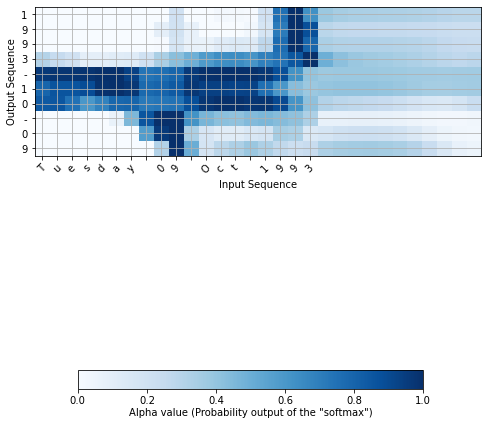

In [25]:
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "Tuesday 09 Oct 1993", num = 7, n_s = 64);